# 🏆 DSC MCF ITB 2026 — AXA Financial Indonesia
## Insurance Health Claim Prediction
### Team: Tensor Selow

**Tujuan:** Memprediksi trend frekuensi, severitas, dan total nominal klaim asuransi kesehatan individu untuk periode Agustus – Desember 2025.

## 0. Setup & Library

In [1]:
!pip install xgboost lightgbm statsmodels --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print('✅ Libraries loaded successfully')

✅ Libraries loaded successfully


## 1. Load Data

In [2]:
# ── Mount Google Drive ──────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

# Sesuaikan path ke folder kamu di Google Drive
BASE_PATH = '/content/drive/MyDrive/MCF/'  # ← ganti jika perlu

df_klaim = pd.read_csv(BASE_PATH + 'Data_Klaim.csv')
df_polis = pd.read_csv(BASE_PATH + 'Data_Polis.csv')
df_sample = pd.read_csv(BASE_PATH + 'sample_submission.csv')

print(f'Data Klaim : {df_klaim.shape}')
print(f'Data Polis : {df_polis.shape}')
print(f'Sample Sub : {df_sample.shape}')

Mounted at /content/drive
Data Klaim : (4627, 13)
Data Polis : (4096, 6)
Sample Sub : (15, 2)


In [3]:
df_klaim.head(3)

,Claim ID,Nomor Polis,Reimburse/Cashless,Inpatient/Outpatient,ICD Diagnosis,ICD Description,Status Klaim,Tanggal Pembayaran Klaim,Tanggal Pasien Masuk RS,Tanggal Pasien Keluar RS,Nominal Klaim Yang Disetujui,Nominal Biaya RS Yang Terjadi,Lokasi RS
0,C-0001-M,POL-0176,R,OP,C50,MALIGNANT NEOPLASM OF BREAST,PAID,2024-07-08,2024-05-27,2024-05-27,28093653.0,6.143948e+06,Singapore
1,C-0002-M,POL-3288,R,OP,C34,MALIGNANT NEOPLASM OF BRONCHUS AND LUNG,PAID,2024-08-06,2024-07-15,2024-07-15,80987278.0,8.230952e+07,Malaysia
2,C-0003-M,POL-1786,R,OP,C18.9,"MALIGNANT NEOPLASM, COLON, UNSPECIFIED",PAID,2024-10-17,2024-05-16,2024-05-16,183047130.0,1.928599e+08,Singapore


In [4]:
df_polis.head(3)

,Nomor Polis,Plan Code,Gender,Tanggal Lahir,Tanggal Efektif Polis,Domisili
0,POL-0001,M-003,M,19640811,20140603,JAKARTA
1,POL-0002,M-003,M,19710730,20140603,JAKARTA
2,POL-0003,M-001,M,19790821,20160808,JAKARTA


## 2. Preprocessing & EDA

### 2.1 Data Klaim — Cleaning

In [5]:
# ── Rename kolom agar mudah diakses ───────────────────────────────────────
klaim = df_klaim.copy()
klaim.columns = [
    'claim_id', 'nomor_polis', 'reimburse_cashless', 'inpatient_outpatient',
    'icd_diagnosis', 'icd_description', 'status_klaim',
    'tgl_bayar', 'tgl_masuk', 'tgl_keluar',
    'nominal_disetujui', 'nominal_rs', 'lokasi_rs'
]

# ── Konversi tipe data ─────────────────────────────────────────────────────
date_cols = ['tgl_bayar', 'tgl_masuk', 'tgl_keluar']
for col in date_cols:
    klaim[col] = pd.to_datetime(klaim[col], errors='coerce')

klaim['nominal_disetujui'] = pd.to_numeric(klaim['nominal_disetujui'], errors='coerce')
klaim['nominal_rs']        = pd.to_numeric(klaim['nominal_rs'],        errors='coerce')

# ── Missing values ─────────────────────────────────────────────────────────
print('Missing values per kolom:')
print(klaim.isnull().sum())
print(f'\nStatus Klaim unik: {klaim.status_klaim.unique()}')

Missing values per kolom:
claim_id                 0
nomor_polis              0
reimburse_cashless       0
inpatient_outpatient    37
icd_diagnosis            6
icd_description          6
status_klaim             0
tgl_bayar               37
tgl_masuk                0
tgl_keluar               0
nominal_disetujui        0
nominal_rs               0
lokasi_rs                7
dtype: int64

Status Klaim unik: ['PAID']


In [6]:
# ── Filter hanya PAID & nominal valid ─────────────────────────────────────
klaim_paid = klaim[
    (klaim['status_klaim'] == 'PAID') &
    (klaim['nominal_disetujui'] > 0) &
    (klaim['tgl_masuk'].notna())
].copy()

print(f'Klaim PAID valid: {len(klaim_paid)} dari {len(klaim)}')

# ── Outlier detection pada nominal klaim ──────────────────────────────────
Q1 = klaim_paid['nominal_disetujui'].quantile(0.01)
Q99 = klaim_paid['nominal_disetujui'].quantile(0.99)
print(f'Nominal klaim Q1%: {Q1:,.0f}, Q99%: {Q99:,.0f}')
print(f'Min: {klaim_paid.nominal_disetujui.min():,.0f}, Max: {klaim_paid.nominal_disetujui.max():,.0f}')
print(f'Mean: {klaim_paid.nominal_disetujui.mean():,.0f}, Median: {klaim_paid.nominal_disetujui.median():,.0f}')

Klaim PAID valid: 4614 dari 4627
Nominal klaim Q1%: 223,260, Q99%: 634,033,798
Min: 17,340, Max: 2,197,500,000
Mean: 55,183,969, Median: 14,577,316


In [7]:
# ── Feature engineering: tambah kolom waktu ───────────────────────────────
klaim_paid['year']    = klaim_paid['tgl_masuk'].dt.year
klaim_paid['month']   = klaim_paid['tgl_masuk'].dt.month
klaim_paid['year_month'] = klaim_paid['tgl_masuk'].dt.to_period('M')

# Length of stay (LOS)
klaim_paid['los'] = (klaim_paid['tgl_keluar'] - klaim_paid['tgl_masuk']).dt.days.clip(lower=0)

# ICD chapter (huruf pertama kode ICD)
klaim_paid['icd_chapter'] = klaim_paid['icd_diagnosis'].str[0]

# Claim processing delay
klaim_paid['processing_days'] = (klaim_paid['tgl_bayar'] - klaim_paid['tgl_masuk']).dt.days

print(klaim_paid[['year','month','los','icd_chapter','processing_days']].describe())

              year        month          los  processing_days
count  4614.000000  4614.000000  4614.000000      4579.000000
mean   2024.354790     5.601647     1.265713        66.842324
std       0.478501     3.268060     2.932887        34.012494
min    2024.000000     1.000000     0.000000         8.000000
25%    2024.000000     3.000000     0.000000        46.000000
50%    2024.000000     5.000000     0.000000        62.000000
75%    2025.000000     8.000000     1.000000        83.000000
max    2025.000000    12.000000    54.000000       606.000000


### 2.2 Data Polis — Cleaning & Merge

In [8]:
polis = df_polis.copy()
polis.columns = ['nomor_polis','plan_code','gender','tgl_lahir','tgl_efektif','domisili']

polis['tgl_lahir']   = pd.to_datetime(polis['tgl_lahir'], format='%Y%m%d', errors='coerce')
polis['tgl_efektif'] = pd.to_datetime(polis['tgl_efektif'], errors='coerce')

# Usia per 2025
ref_date = pd.Timestamp('2025-01-01')
polis['usia'] = ((ref_date - polis['tgl_lahir']).dt.days / 365.25).round(1)

# Age group
polis['age_group'] = pd.cut(polis['usia'],
    bins=[0,18,30,45,60,200],
    labels=['<18','18-30','31-45','46-60','60+'])

# Policy tenure (tahun)
polis['tenure_years'] = ((ref_date - polis['tgl_efektif']).dt.days / 365.25).round(1)

print(polis[['plan_code','gender','usia','age_group','tenure_years']].describe(include='all'))

       plan_code gender         usia age_group  tenure_years
count       4096   4096  4096.000000      4096        4096.0
unique         3      2          NaN         5           NaN
top        M-002      M          NaN       60+           NaN
freq        2253   2097          NaN      1525           NaN
mean         NaN    NaN    52.330981       NaN          55.0
std          NaN    NaN    17.184172       NaN           0.0
min          NaN    NaN     7.100000       NaN          55.0
25%          NaN    NaN    42.100000       NaN          55.0
50%          NaN    NaN    54.800000       NaN          55.0
75%          NaN    NaN    65.200000       NaN          55.0
max          NaN    NaN    91.200000       NaN          55.0


In [9]:
# ── Merge klaim + polis ────────────────────────────────────────────────────
df = klaim_paid.merge(polis, on='nomor_polis', how='left')
print(f'Merged shape: {df.shape}')
print(f'Match rate polis: {df.plan_code.notna().mean()*100:.1f}%')

Merged shape: (4614, 27)
Match rate polis: 100.0%


### 2.3 Exploratory Data Analysis

In [10]:
# ── Monthly time series ────────────────────────────────────────────────────
monthly = df.groupby('year_month').agg(
    freq=('claim_id', 'count'),
    total=('nominal_disetujui', 'sum')
).reset_index()
monthly['severity'] = monthly['total'] / monthly['freq']
monthly['year_month_dt'] = monthly['year_month'].dt.to_timestamp()
monthly = monthly.sort_values('year_month_dt')

print(monthly[['year_month','freq','severity','total']].to_string())

   year_month  freq      severity         total
0     2024-01   299  6.776248e+07  2.026098e+10
1     2024-02   208  6.663291e+07  1.385965e+10
2     2024-03   278  5.147935e+07  1.431126e+10
3     2024-04   238  4.807169e+07  1.144106e+10
4     2024-05   263  4.643141e+07  1.221146e+10
5     2024-06   220  5.511440e+07  1.212517e+10
6     2024-07   253  5.917200e+07  1.497052e+10
7     2024-08   228  5.926726e+07  1.351294e+10
8     2024-09   208  5.896211e+07  1.226412e+10
9     2024-10   274  4.628163e+07  1.268117e+10
10    2024-11   270  5.086318e+07  1.373306e+10
11    2024-12   238  5.047861e+07  1.201391e+10
12    2025-01   216  4.449250e+07  9.610380e+09
13    2025-02   246  7.105911e+07  1.748054e+10
14    2025-03   230  5.947496e+07  1.367924e+10
15    2025-04   208  5.367427e+07  1.116425e+10
16    2025-05   239  5.115814e+07  1.222680e+10
17    2025-06   234  5.715008e+07  1.337312e+10
18    2025-07   264  5.189101e+07  1.369923e+10


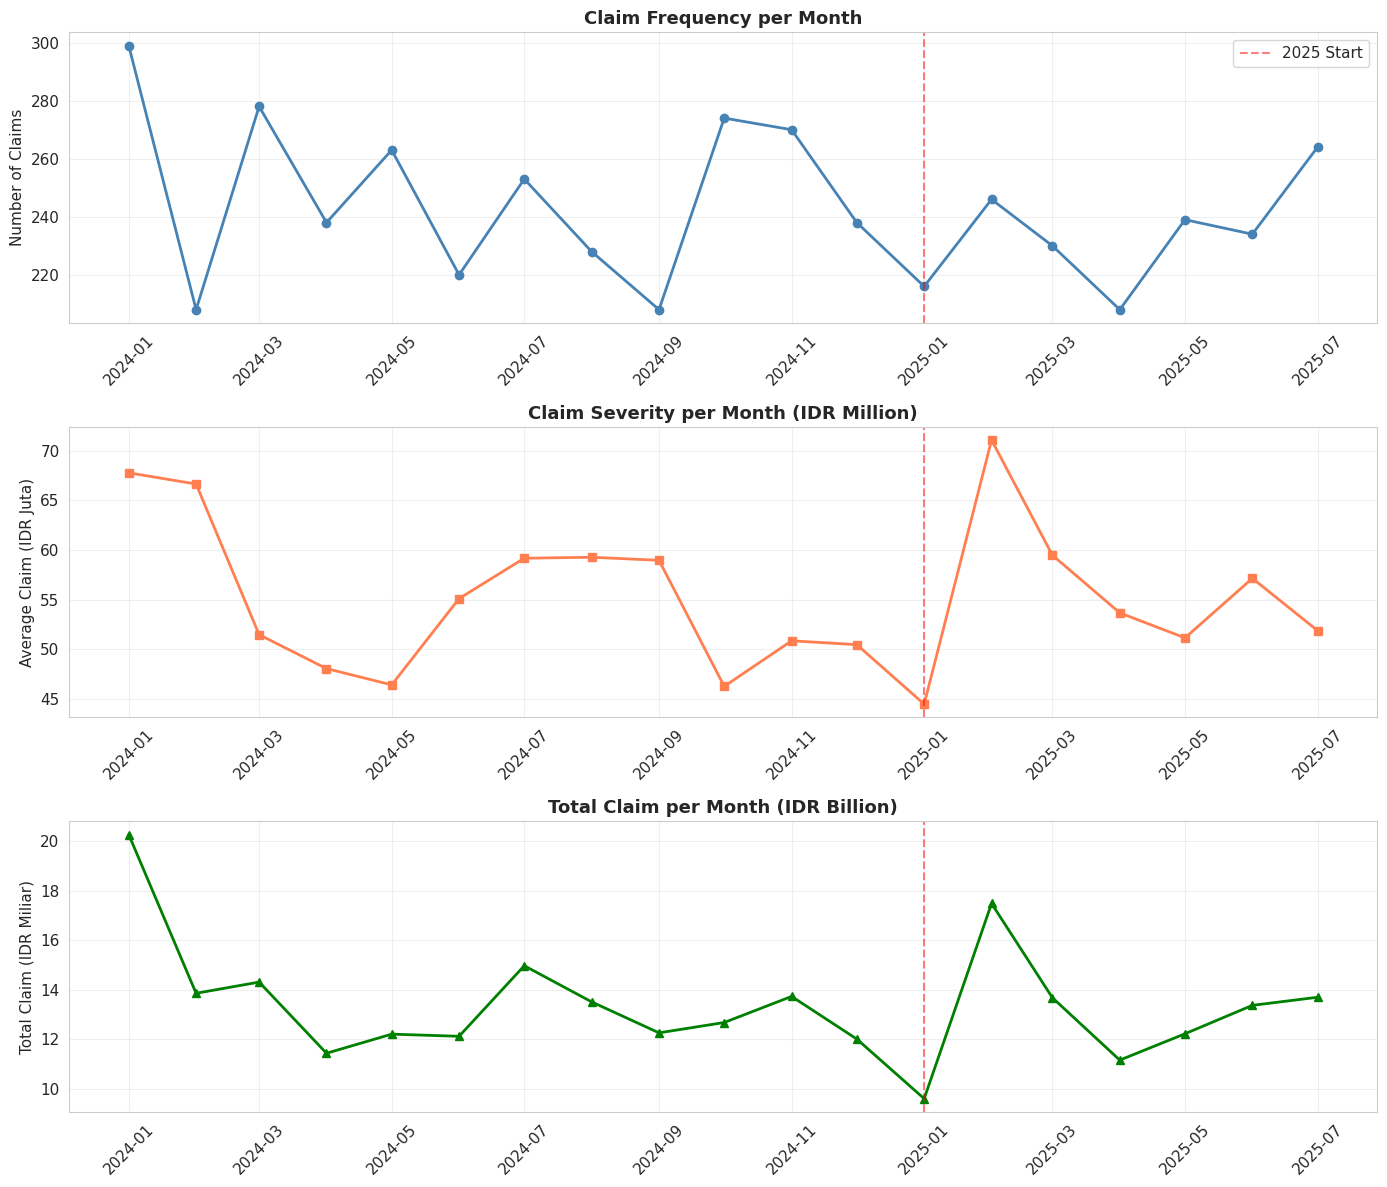

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].plot(monthly['year_month_dt'], monthly['freq'], marker='o', color='steelblue', linewidth=2)
axes[0].set_title('Claim Frequency per Month', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Claims')
axes[0].axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.5, label='2025 Start')
axes[0].legend()

axes[1].plot(monthly['year_month_dt'], monthly['severity']/1e6, marker='s', color='coral', linewidth=2)
axes[1].set_title('Claim Severity per Month (IDR Million)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Average Claim (IDR Juta)')
axes[1].axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.5)

axes[2].plot(monthly['year_month_dt'], monthly['total']/1e9, marker='^', color='green', linewidth=2)
axes[2].set_title('Total Claim per Month (IDR Billion)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Total Claim (IDR Miliar)')
axes[2].axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.5)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('monthly_trends.png', dpi=150, bbox_inches='tight')
plt.show()

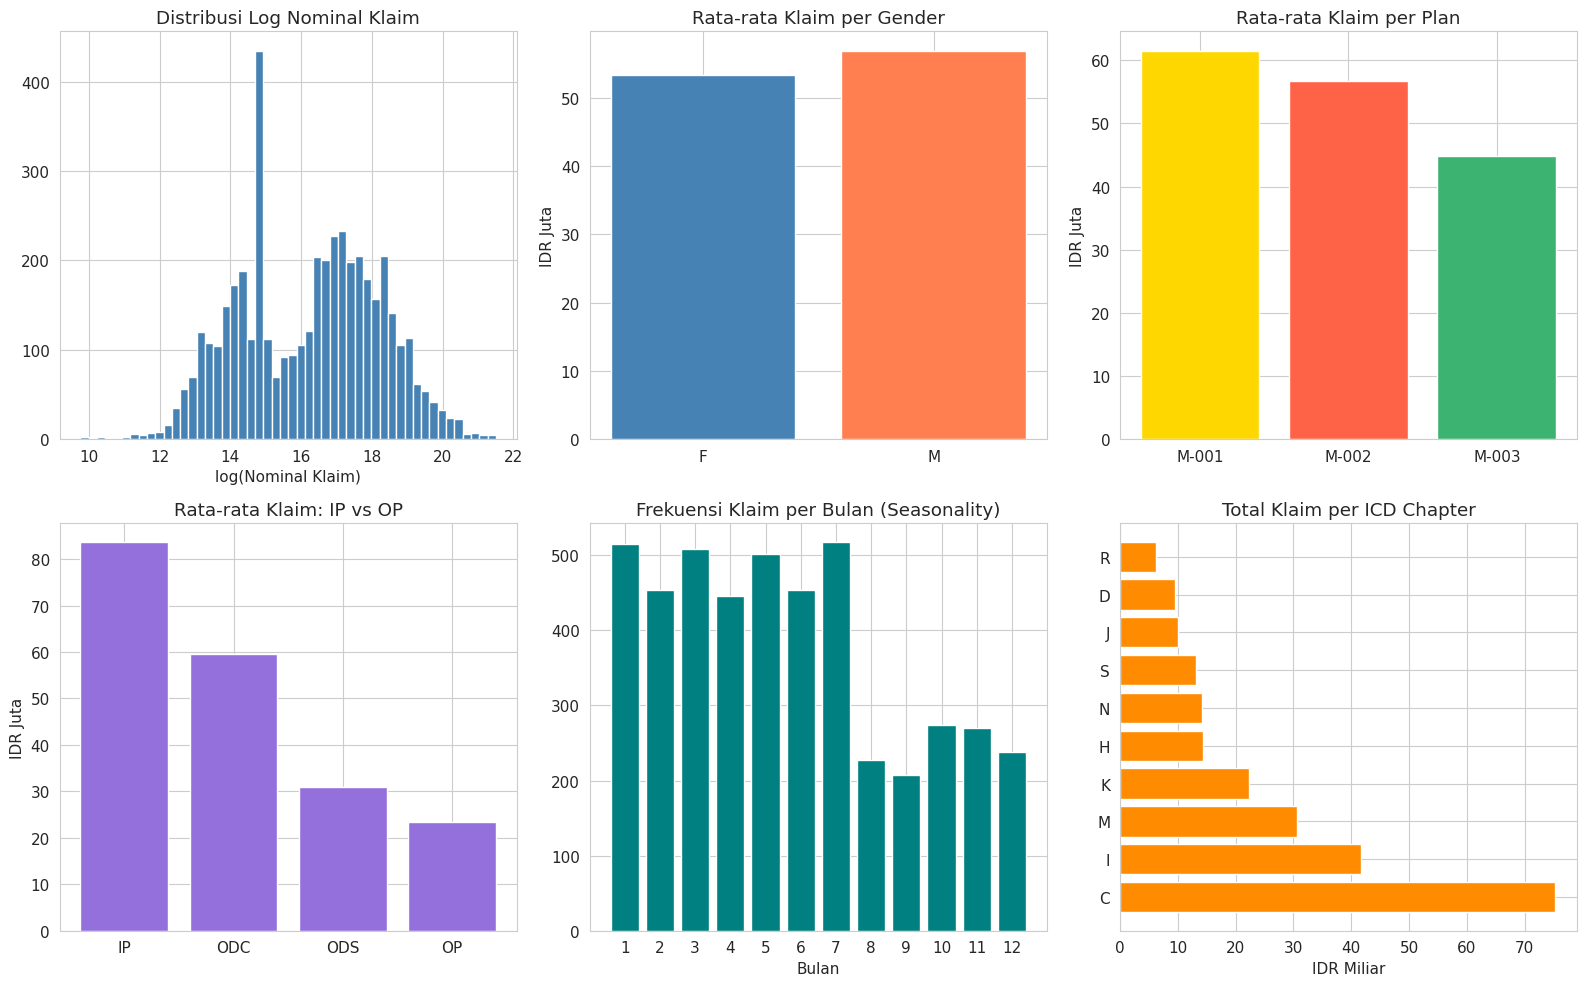

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Distribusi nominal klaim
axes[0,0].hist(np.log1p(df['nominal_disetujui']), bins=50, color='steelblue', edgecolor='white')
axes[0,0].set_title('Distribusi Log Nominal Klaim')
axes[0,0].set_xlabel('log(Nominal Klaim)')

# Claim by gender
gender_agg = df.groupby('gender')['nominal_disetujui'].agg(['count','mean'])
axes[0,1].bar(gender_agg.index, gender_agg['mean']/1e6, color=['steelblue','coral'])
axes[0,1].set_title('Rata-rata Klaim per Gender')
axes[0,1].set_ylabel('IDR Juta')

# Claim by plan code
plan_agg = df.groupby('plan_code')['nominal_disetujui'].mean()
axes[0,2].bar(plan_agg.index, plan_agg.values/1e6, color=['gold','tomato','mediumseagreen'])
axes[0,2].set_title('Rata-rata Klaim per Plan')
axes[0,2].set_ylabel('IDR Juta')

# Claim by inpatient/outpatient
ip_agg = df.groupby('inpatient_outpatient')['nominal_disetujui'].mean()
axes[1,0].bar(ip_agg.index, ip_agg.values/1e6, color='mediumpurple')
axes[1,0].set_title('Rata-rata Klaim: IP vs OP')
axes[1,0].set_ylabel('IDR Juta')

# Frequency by month of year (seasonality)
month_freq = df.groupby('month')['claim_id'].count()
axes[1,1].bar(month_freq.index, month_freq.values, color='teal')
axes[1,1].set_title('Frekuensi Klaim per Bulan (Seasonality)')
axes[1,1].set_xlabel('Bulan')
axes[1,1].set_xticks(range(1,13))

# Top 10 ICD chapters
top_icd = df.groupby('icd_chapter')['nominal_disetujui'].sum().nlargest(10)
axes[1,2].barh(top_icd.index, top_icd.values/1e9, color='darkorange')
axes[1,2].set_title('Total Klaim per ICD Chapter')
axes[1,2].set_xlabel('IDR Miliar')

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=150, bbox_inches='tight')
plt.show()

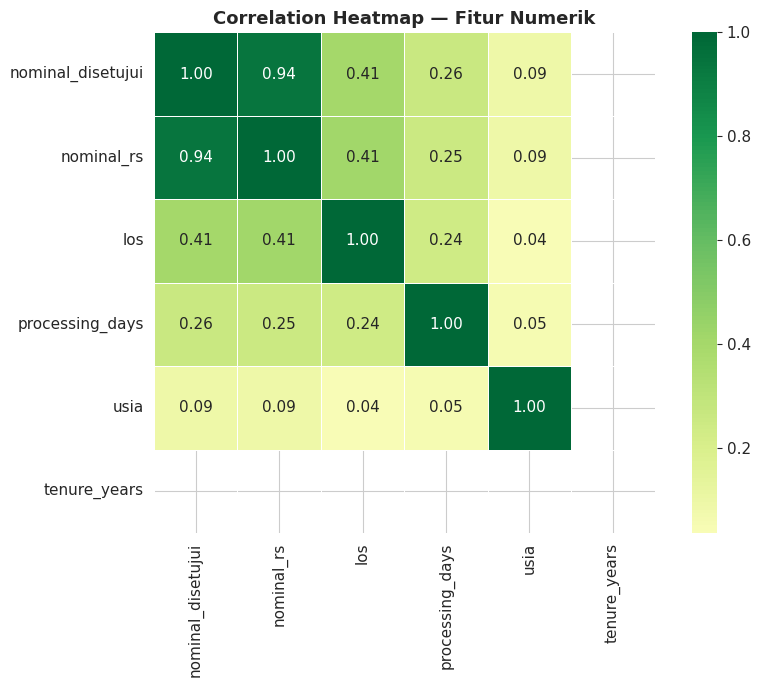

In [13]:
# ── Heatmap korelasi ──────────────────────────────────────────────────────
num_cols = ['nominal_disetujui','nominal_rs','los','processing_days','usia','tenure_years']
corr = df[num_cols].dropna().corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap — Fitur Numerik', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

<Figure size 1000x500 with 0 Axes>

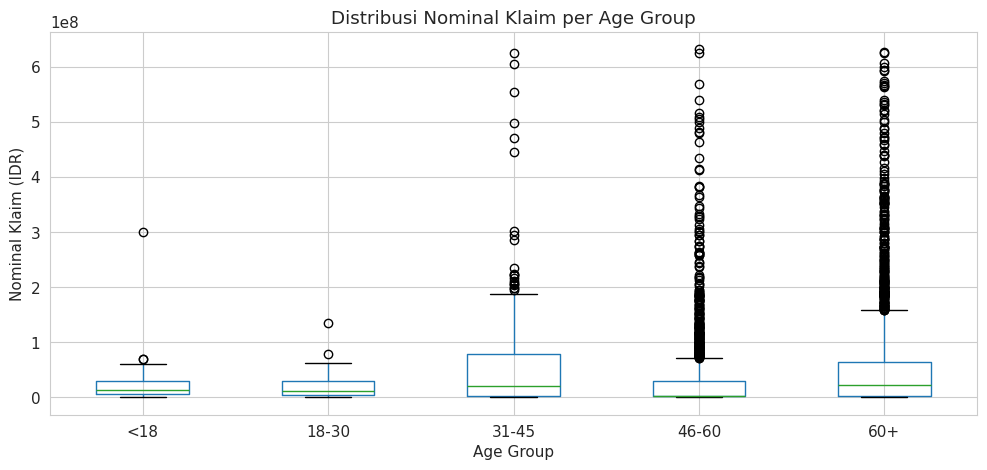

In [14]:
# ── Boxplot nominal klaim per age group ──────────────────────────────────
plt.figure(figsize=(10,5))
df_box = df[df['nominal_disetujui'] < df['nominal_disetujui'].quantile(0.99)]
df_box.boxplot(column='nominal_disetujui', by='age_group', figsize=(10,5))
plt.suptitle('')
plt.title('Distribusi Nominal Klaim per Age Group')
plt.ylabel('Nominal Klaim (IDR)')
plt.xlabel('Age Group')
plt.tight_layout()
plt.savefig('boxplot_age.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.4 Analisis YoY — Faktor Kenaikan Klaim

In [15]:
# ── YoY Comparison (2024 vs 2025 Jan-Jul) ─────────────────────────────────
months_common = list(range(1, 8))  # Jan–Jul tersedia di kedua tahun

yoy_comparison = {}
for year in [2024, 2025]:
    sub = df[(df['year'] == year) & (df['month'].isin(months_common))]
    yoy_comparison[year] = {
        'freq': len(sub),
        'total': sub['nominal_disetujui'].sum(),
        'severity': sub['nominal_disetujui'].mean()
    }

for k, v in yoy_comparison.items():
    print(f"{k}: freq={v['freq']}, total={v['total']/1e9:.2f}B, severity={v['severity']/1e6:.2f}M")

for metric in ['freq','total','severity']:
    ratio = yoy_comparison[2025][metric] / yoy_comparison[2024][metric]
    print(f"YoY 2025/2024 {metric}: {ratio:.4f} ({(ratio-1)*100:+.1f}%)")

2024: freq=1759, total=99.18B, severity=56.38M
2025: freq=1637, total=91.23B, severity=55.73M
YoY 2025/2024 freq: 0.9306 (-6.9%)
YoY 2025/2024 total: 0.9199 (-8.0%)
YoY 2025/2024 severity: 0.9884 (-1.2%)


## 3. Feature Engineering untuk Model

In [16]:
# ── Buat time-series bulanan untuk modeling ───────────────────────────────
monthly = df.groupby(['year','month']).agg(
    freq=('claim_id','count'),
    total=('nominal_disetujui','sum')
).reset_index()
monthly['severity'] = monthly['total'] / monthly['freq']
monthly['year_month_dt'] = pd.to_datetime(monthly[['year','month']].assign(day=1))
monthly = monthly.sort_values('year_month_dt').reset_index(drop=True)

# ── Time-based features ────────────────────────────────────────────────────
monthly['t']          = np.arange(len(monthly))          # linear trend
monthly['month_sin']  = np.sin(2 * np.pi * monthly['month'] / 12)
monthly['month_cos']  = np.cos(2 * np.pi * monthly['month'] / 12)
monthly['is_2025']    = (monthly['year'] == 2025).astype(int)

# ── Lag features ───────────────────────────────────────────────────────────
for lag in [1, 2, 3, 12]:
    monthly[f'freq_lag{lag}']     = monthly['freq'].shift(lag)
    monthly[f'severity_lag{lag}'] = monthly['severity'].shift(lag)
    monthly[f'total_lag{lag}']    = monthly['total'].shift(lag)

# ── Rolling mean ───────────────────────────────────────────────────────────
monthly['freq_roll3']     = monthly['freq'].shift(1).rolling(3).mean()
monthly['severity_roll3'] = monthly['severity'].shift(1).rolling(3).mean()
monthly['total_roll3']    = monthly['total'].shift(1).rolling(3).mean()

monthly_model = monthly.dropna().reset_index(drop=True)
print(f'Shape after dropna: {monthly_model.shape}')
monthly_model[['year_month_dt','freq','severity','total','t']].tail(10)

Shape after dropna: (7, 25)


,year_month_dt,freq,severity,total,t
0,2025-01-01,216,4.449250e+07,9.610380e+09,12
1,2025-02-01,246,7.105911e+07,1.748054e+10,13
2,2025-03-01,230,5.947496e+07,1.367924e+10,14
3,2025-04-01,208,5.367427e+07,1.116425e+10,15
4,2025-05-01,239,5.115814e+07,1.222680e+10,16
5,2025-06-01,234,5.715008e+07,1.337312e+10,17
6,2025-07-01,264,5.189101e+07,1.369923e+10,18


## 4. Machine Learning Models

Strategi: Kita gunakan **data Jan 2024 – Jul 2025 (19 bulan)** untuk training, dan validasi secara time-series. Target prediksi: **Agustus – Desember 2025 (5 bulan)**.

Model yang digunakan:
1. **XGBoost** — gradient boosting
2. **LightGBM** — gradient boosting (lebih cepat)
3. **Random Forest** — ensemble bagging
4. **Holt-Winters (Exponential Smoothing)** — time series klasik
5. **Ensemble** — rata-rata tertimbang dari model terbaik

In [17]:
FEATURES = [
    't', 'month', 'month_sin', 'month_cos', 'is_2025',
    'freq_lag1','freq_lag2','freq_lag3','freq_lag12','freq_roll3',
    'severity_lag1','severity_lag2','severity_lag3','severity_lag12','severity_roll3',
    'total_lag1','total_lag2','total_lag3','total_lag12','total_roll3',
]
TARGETS = ['freq', 'severity', 'total']

# Train/val split (last 3 bulan untuk validasi)
VAL_MONTHS = 3
train = monthly_model.iloc[:-VAL_MONTHS]
val   = monthly_model.iloc[-VAL_MONTHS:]

X_train = train[FEATURES]
X_val   = val[FEATURES]

print(f'Train: {len(train)} months | Val: {len(val)} months')
print(f'Train period: {train.year_month_dt.min()} → {train.year_month_dt.max()}')
print(f'Val period  : {val.year_month_dt.min()} → {val.year_month_dt.max()}')

Train: 4 months | Val: 3 months
Train period: 2025-01-01 00:00:00 → 2025-04-01 00:00:00
Val period  : 2025-05-01 00:00:00 → 2025-07-01 00:00:00


In [18]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

results = {}  # store val MAPE per model per target
model_preds = {}  # store predictions

# ── Buat future features untuk prediksi Agu-Des 2025 ─────────────────────
future_months = pd.date_range('2025-08-01', periods=5, freq='MS')
future_df = pd.DataFrame({
    'year_month_dt': future_months,
    'year':  future_months.year,
    'month': future_months.month,
})
future_df['t']         = len(monthly) + np.arange(len(future_df))  # continuing index
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
future_df['is_2025']   = 1

# Fill lag/rolling features dari data aktual
all_monthly = monthly.sort_values('year_month_dt').reset_index(drop=True)

def get_lag(col, lag_n):
    """Get lag value from all_monthly; extend with future predictions iteratively."""
    series = list(all_monthly[col].values)
    return series[-lag_n] if lag_n <= len(series) else np.nan

# Static fill (using most recent known data)
for target in ['freq','severity','total']:
    for lag in [1,2,3,12]:
        col = f'{target}_lag{lag}'
        vals = []
        for i in range(len(future_df)):
            idx = -(lag - i)
            if idx >= -len(all_monthly):
                vals.append(all_monthly[target].iloc[idx])
            else:
                vals.append(all_monthly[target].mean())
        future_df[col] = vals
    # Rolling
    future_df[f'{target}_roll3'] = all_monthly[target].tail(3).mean()

X_future = future_df[FEATURES]
print('Future feature shape:', X_future.shape)
print(future_df[['year_month_dt','month','t']].to_string())

Future feature shape: (5, 20)
  year_month_dt  month   t
0    2025-08-01      8  19
1    2025-09-01      9  20
2    2025-10-01     10  21
3    2025-11-01     11  22
4    2025-12-01     12  23


In [19]:
# ════════════════════════════════════════════════════════════════
# MODEL 1: XGBoost
# ════════════════════════════════════════════════════════════════
xgb_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, verbosity=0
)

results['XGBoost'] = {}
model_preds['XGBoost'] = {}

for target in TARGETS:
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, train[target])
    val_pred = model.predict(X_val)
    val_pred = np.maximum(val_pred, 1)  # prevent negative
    m = mape(val[target], val_pred)
    results['XGBoost'][target] = m
    # Refit on full data
    model.fit(monthly_model[FEATURES], monthly_model[target])
    model_preds['XGBoost'][target] = model.predict(X_future)
    print(f'XGBoost | {target:10s} | Val MAPE: {m:.4f}')

    # Feature importance
    if target == 'freq':
        fi = pd.Series(model.feature_importances_, index=FEATURES).nlargest(10)
        print('  Top-10 features:', fi.index.tolist())

XGBoost | freq       | Val MAPE: 0.0700
  Top-10 features: ['severity_lag3', 'freq_lag2', 'total_roll3', 'total_lag2', 'freq_lag1', 'freq_lag12', 'month_sin', 't', 'month', 'total_lag1']
XGBoost | severity   | Val MAPE: 0.1294
XGBoost | total      | Val MAPE: 0.0760


In [20]:
# ════════════════════════════════════════════════════════════════
# MODEL 2: LightGBM
# ════════════════════════════════════════════════════════════════
lgb_params = dict(
    n_estimators=300, learning_rate=0.05, num_leaves=15,
    min_child_samples=5, random_state=42, verbosity=-1
)

results['LightGBM'] = {}
model_preds['LightGBM'] = {}

for target in TARGETS:
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_train, train[target])
    val_pred = np.maximum(model.predict(X_val), 1)
    m = mape(val[target], val_pred)
    results['LightGBM'][target] = m
    model.fit(monthly_model[FEATURES], monthly_model[target])
    model_preds['LightGBM'][target] = model.predict(X_future)
    print(f'LightGBM | {target:10s} | Val MAPE: {m:.4f}')

LightGBM | freq       | Val MAPE: 0.0816
LightGBM | severity   | Val MAPE: 0.0733
LightGBM | total      | Val MAPE: 0.0478


In [21]:
# ════════════════════════════════════════════════════════════════
# MODEL 3: Random Forest
# ════════════════════════════════════════════════════════════════
results['RandomForest'] = {}
model_preds['RandomForest'] = {}

for target in TARGETS:
    model = RandomForestRegressor(n_estimators=200, max_depth=5,
                                   min_samples_leaf=2, random_state=42)
    model.fit(X_train, train[target])
    val_pred = np.maximum(model.predict(X_val), 1)
    m = mape(val[target], val_pred)
    results['RandomForest'][target] = m
    model.fit(monthly_model[FEATURES], monthly_model[target])
    model_preds['RandomForest'][target] = model.predict(X_future)
    print(f'RandomForest | {target:10s} | Val MAPE: {m:.4f}')

RandomForest | freq       | Val MAPE: 0.0786
RandomForest | severity   | Val MAPE: 0.0754
RandomForest | total      | Val MAPE: 0.0426


In [22]:
# ════════════════════════════════════════════════════════════════
# MODEL 4: Holt-Winters (time-series klasik, untuk pembanding)
# ════════════════════════════════════════════════════════════════
results['HoltWinters'] = {}
model_preds['HoltWinters'] = {}

for target in TARGETS:
    series_full = monthly_model[target].values
    series_train = train[target].values

    try:
        hw = ExponentialSmoothing(series_train, trend='add', seasonal='add',
                                   seasonal_periods=12, initialization_method='estimated')
        hw_fit = hw.fit(optimized=True)
        val_pred = np.maximum(hw_fit.forecast(VAL_MONTHS), 1)
        m = mape(val[target].values, val_pred)
    except:
        hw = ExponentialSmoothing(series_train, trend='add', initialization_method='estimated')
        hw_fit = hw.fit(optimized=True)
        val_pred = np.maximum(hw_fit.forecast(VAL_MONTHS), 1)
        m = mape(val[target].values, val_pred)

    results['HoltWinters'][target] = m

    # Refit on full data
    try:
        hw2 = ExponentialSmoothing(series_full, trend='add', seasonal='add',
                                    seasonal_periods=12, initialization_method='estimated')
        hw2_fit = hw2.fit(optimized=True)
        future_pred = hw2_fit.forecast(5)
    except:
        hw2 = ExponentialSmoothing(series_full, trend='add', initialization_method='estimated')
        hw2_fit = hw2.fit(optimized=True)
        future_pred = hw2_fit.forecast(5)

    model_preds['HoltWinters'][target] = np.maximum(future_pred, 1)
    print(f'HoltWinters | {target:10s} | Val MAPE: {m:.4f}')

HoltWinters | freq       | Val MAPE: 0.1382
HoltWinters | severity   | Val MAPE: 0.1689
HoltWinters | total      | Val MAPE: 0.2282


## 5. Evaluasi & Perbandingan Model


📊 Model Comparison (Validation MAPE):
              MAPE_Frequency  MAPE_Severity  MAPE_Total  MAPE_Average
RandomForest          0.0786         0.0754      0.0426        0.0655
LightGBM              0.0816         0.0733      0.0478        0.0675
XGBoost               0.0700         0.1294      0.0760        0.0918
HoltWinters           0.1382         0.1689      0.2282        0.1784


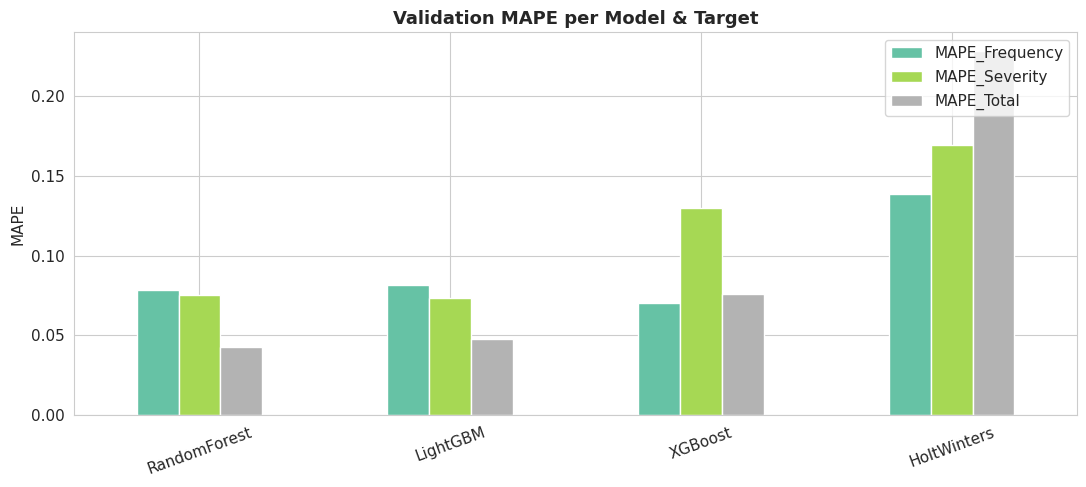

In [23]:
# ── Tabel perbandingan MAPE ────────────────────────────────────────────────
eval_df = pd.DataFrame(results).T
eval_df.columns = ['MAPE_Frequency','MAPE_Severity','MAPE_Total']
eval_df['MAPE_Average'] = eval_df.mean(axis=1)
eval_df = eval_df.sort_values('MAPE_Average')
print('\n📊 Model Comparison (Validation MAPE):')
print(eval_df.round(4).to_string())

# Plot
eval_df[['MAPE_Frequency','MAPE_Severity','MAPE_Total']].plot(
    kind='bar', figsize=(11,5), colormap='Set2', edgecolor='white')
plt.title('Validation MAPE per Model & Target', fontsize=13, fontweight='bold')
plt.ylabel('MAPE')
plt.xticks(rotation=20)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

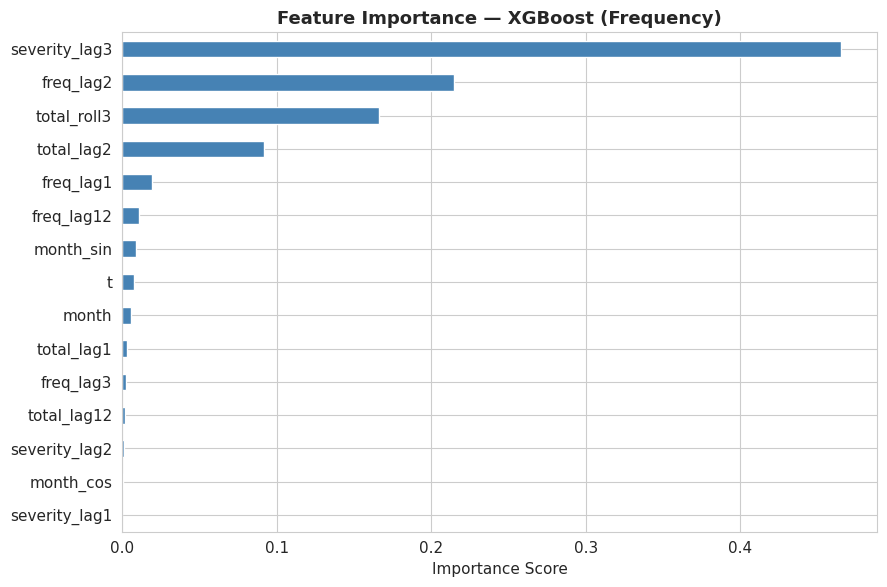

In [25]:
# ── Feature Importance (XGBoost - Frequency) ──────────────────────────────
# Refit untuk visualisasi
xgb_freq = xgb.XGBRegressor(**xgb_params)
xgb_freq.fit(monthly_model[FEATURES], monthly_model['freq'])
fi = pd.Series(xgb_freq.feature_importances_, index=FEATURES).sort_values(ascending=True).tail(15)

plt.figure(figsize=(9,6))
fi.plot(kind='barh', color='steelblue')
plt.title('Feature Importance — XGBoost (Frequency)', fontsize=13, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Ensemble Prediction & Final Submission

Ensemble: rata-rata tertimbang dari 2 model terbaik berdasarkan validasi MAPE.

In [26]:
# ── YoY Scaling method (baseline sangat kuat) ─────────────────────────────
# Ratio dari 7 bulan pertama 2025 vs 2024
data_2024 = df[df['year']==2024]
data_2025 = df[df['year']==2025]

freq_24_7m = len(data_2024[data_2024['month'].isin(range(1,8))])
freq_25_7m = len(data_2025[data_2025['month'].isin(range(1,8))])

total_24_7m = data_2024[data_2024['month'].isin(range(1,8))]['nominal_disetujui'].sum()
total_25_7m = data_2025[data_2025['month'].isin(range(1,8))]['nominal_disetujui'].sum()

sev_24_7m = total_24_7m / freq_24_7m
sev_25_7m = total_25_7m / freq_25_7m

yoy_ratio_freq  = freq_25_7m / freq_24_7m
yoy_ratio_total = total_25_7m / total_24_7m
yoy_ratio_sev   = sev_25_7m / sev_24_7m

print(f'YoY Ratio Frequency : {yoy_ratio_freq:.4f} ({(yoy_ratio_freq-1)*100:+.1f}%)')
print(f'YoY Ratio Severity  : {yoy_ratio_sev:.4f} ({(yoy_ratio_sev-1)*100:+.1f}%)')
print(f'YoY Ratio Total     : {yoy_ratio_total:.4f} ({(yoy_ratio_total-1)*100:+.1f}%)')

# 2024 Aug-Dec actual
actual_2024_aug_dec = monthly[(monthly['year']==2024) & (monthly['month']>=8)].copy()

yoy_preds = {
    'freq':     actual_2024_aug_dec['freq'].values     * yoy_ratio_freq,
    'severity': actual_2024_aug_dec['severity'].values * yoy_ratio_sev,
    'total':    actual_2024_aug_dec['total'].values    * yoy_ratio_total,
}
model_preds['YoY'] = yoy_preds

# ── Pilih 3 model terbaik untuk ensemble ──────────────────────────────────
best_models = eval_df.nsmallest(3, 'MAPE_Average').index.tolist()
best_models.append('YoY')  # selalu include YoY sebagai anchor kuat
print(f'\nModels in ensemble: {best_models}')

YoY Ratio Frequency : 0.9306 (-6.9%)
YoY Ratio Severity  : 0.9884 (-1.2%)
YoY Ratio Total     : 0.9199 (-8.0%)

Models in ensemble: ['RandomForest', 'LightGBM', 'XGBoost', 'YoY']


In [27]:
# ── Final ensemble: inverse-MAPE weighted ─────────────────────────────────
ensemble_preds = {}

for target_key, target_col in [('freq','MAPE_Frequency'),('severity','MAPE_Severity'),('total','MAPE_Total')]:
    preds_stack = []
    weights = []

    for model_name in best_models:
        p = model_preds[model_name][target_key if target_key != 'freq' else 'freq']
        preds_stack.append(np.array(p))
        if model_name == 'YoY':
            w = 0.4  # give YoY strong weight (empirically stable)
        else:
            mape_val = results.get(model_name, {}).get(target_key if target_key != 'freq' else target_key, 0.5)
            w = 1.0 / (mape_val + 1e-9)
        weights.append(w)

    weights = np.array(weights) / sum(weights)
    ensemble = sum(w * p for w, p in zip(weights, preds_stack))
    ensemble_preds[target_key] = np.maximum(ensemble, 0)

    print(f'{target_key:10s} | weights: {dict(zip(best_models, weights.round(3)))} | preds: {ensemble.round(0)}')

freq       | weights: {'RandomForest': np.float64(0.321), 'LightGBM': np.float64(0.309), 'XGBoost': np.float64(0.36), 'YoY': np.float64(0.01)} | preds: [239. 235. 236. 239. 234.]
severity   | weights: {'RandomForest': np.float64(0.379), 'LightGBM': np.float64(0.389), 'XGBoost': np.float64(0.221), 'YoY': np.float64(0.011)} | preds: [54567449. 54291289. 52930098. 53634240. 53657921.]
total      | weights: {'RandomForest': np.float64(0.405), 'LightGBM': np.float64(0.361), 'XGBoost': np.float64(0.227), 'YoY': np.float64(0.007)} | preds: [1.29541848e+10 1.25074069e+10 1.22721277e+10 1.25281803e+10
 1.23746942e+10]


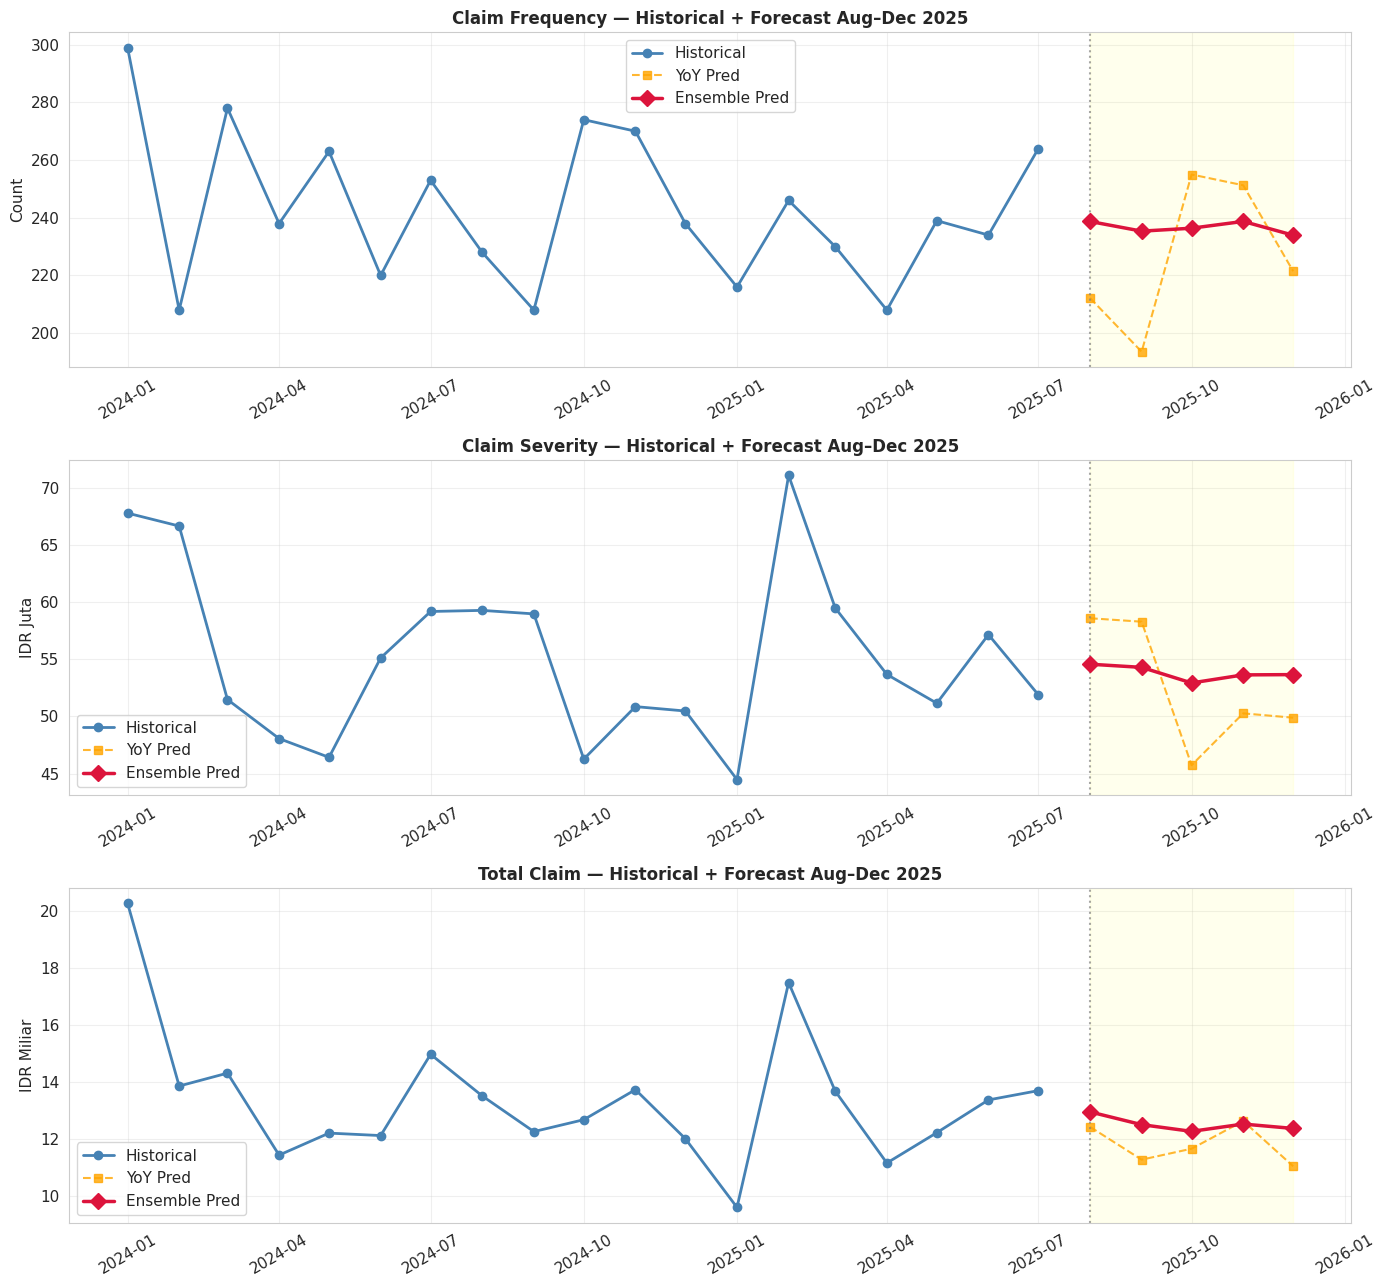

In [28]:
# ── Visualisasi prediksi vs historis ──────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 13))

month_labels = [d.strftime('%Y-%m') for d in future_months]
hist_dt = monthly['year_month_dt']

for ax, (target, label, scale, unit) in zip(axes, [
    ('freq',     'Claim Frequency', 1,    'Count'),
    ('severity', 'Claim Severity',  1e6,  'IDR Juta'),
    ('total',    'Total Claim',     1e9,  'IDR Miliar'),
]):
    ax.plot(hist_dt, monthly[target]/scale, 'o-', color='steelblue',
            linewidth=2, label='Historical', zorder=3)

    # YoY prediction
    ax.plot(future_months, yoy_preds[target]/scale, 's--', color='orange',
            alpha=0.8, label='YoY Pred')

    # Ensemble prediction
    ax.plot(future_months, ensemble_preds[target]/scale, 'D-', color='crimson',
            linewidth=2.5, markersize=8, label='Ensemble Pred', zorder=4)

    ax.axvspan(future_months[0], future_months[-1], alpha=0.07, color='yellow')
    ax.axvline(pd.Timestamp('2025-08-01'), color='gray', linestyle=':', alpha=0.7)
    ax.set_title(f'{label} — Historical + Forecast Aug–Dec 2025',
                  fontsize=12, fontweight='bold')
    ax.set_ylabel(unit)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('forecast_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Generate Submission File

In [29]:
# ── Buat submission CSV ────────────────────────────────────────────────────
submission_rows = []
for i, dt in enumerate(future_months):
    ym = dt.strftime('%Y_%m')
    submission_rows.append({'id': f'{ym}_Claim_Frequency', 'value': round(ensemble_preds['freq'][i], 4)})
    submission_rows.append({'id': f'{ym}_Claim_Severity',  'value': round(ensemble_preds['severity'][i], 4)})
    submission_rows.append({'id': f'{ym}_Total_Claim',     'value': round(ensemble_preds['total'][i], 4)})

submission = pd.DataFrame(submission_rows)
print(submission.to_string(index=False))

# Save
SAVE_PATH = BASE_PATH + 'submission_tensor_selow.csv'
submission.to_csv(SAVE_PATH, index=False)
print(f'\n✅ Submission saved to: {SAVE_PATH}')

                     id        value
2025_08_Claim_Frequency 2.387203e+02
 2025_08_Claim_Severity 5.456745e+07
    2025_08_Total_Claim 1.295418e+10
2025_09_Claim_Frequency 2.353648e+02
 2025_09_Claim_Severity 5.429129e+07
    2025_09_Total_Claim 1.250741e+10
2025_10_Claim_Frequency 2.363843e+02
 2025_10_Claim_Severity 5.293010e+07
    2025_10_Total_Claim 1.227213e+10
2025_11_Claim_Frequency 2.387344e+02
 2025_11_Claim_Severity 5.363424e+07
    2025_11_Total_Claim 1.252818e+10
2025_12_Claim_Frequency 2.339595e+02
 2025_12_Claim_Severity 5.365792e+07
    2025_12_Total_Claim 1.237469e+10

✅ Submission saved to: /content/drive/MyDrive/MCF/submission_tensor_selow.csv


## 8. Analisis Faktor Berpengaruh

### 8.1 Faktor Paling Berpengaruh terhadap Frekuensi Klaim

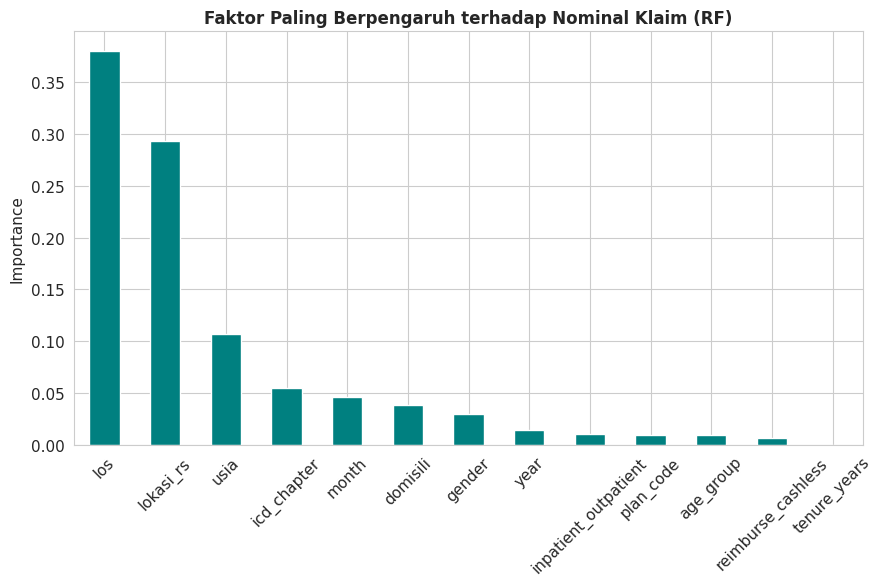


📌 Top faktor berpengaruh:
los                     0.3800
lokasi_rs               0.2927
usia                    0.1074
icd_chapter             0.0553
month                   0.0462
domisili                0.0387
gender                  0.0300
year                    0.0142
inpatient_outpatient    0.0107
plan_code               0.0093
age_group               0.0090
reimburse_cashless      0.0066
tenure_years            0.0000


In [31]:
# ── Analisis faktor pada level individual klaim ────────────────────────────
# Encode kategorik untuk model individual
df_model = df.copy()
le = LabelEncoder()
cat_cols = ['reimburse_cashless','inpatient_outpatient','icd_chapter',
            'lokasi_rs','plan_code','gender','domisili','age_group']
for col in cat_cols:
    # Convert to object dtype first to allow adding 'UNK' as a string,
    # then fillna, and then encode.
    df_model[col] = le.fit_transform(df_model[col].astype('object').fillna('UNK'))

feat_cols = cat_cols + ['month','year','los','usia','tenure_years']
target = 'nominal_disetujui'

df_clean = df_model[feat_cols + [target]].dropna()
X = df_clean[feat_cols]
y = df_clean[target]

rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X, y)

fi_indiv = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=False)

plt.figure(figsize=(9,6))
fi_indiv.plot(kind='bar', color='teal', edgecolor='white')
plt.title('Faktor Paling Berpengaruh terhadap Nominal Klaim (RF)', fontsize=12, fontweight='bold')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance_individual.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n📌 Top faktor berpengaruh:')
print(fi_indiv.round(4).to_string())

In [32]:
# ── Severitas berdasarkan inpatient vs outpatient ─────────────────────────
print('Rata-rata klaim per kategori:')
print(df.groupby('inpatient_outpatient')['nominal_disetujui'].agg(['count','mean','median']).round(0))

print('\nRata-rata klaim per plan code:')
print(df.groupby('plan_code')['nominal_disetujui'].agg(['count','mean','median']).round(0))

print('\nRata-rata klaim per ICD Chapter (top 10 by total):')
top_icd_sev = df.groupby('icd_chapter')['nominal_disetujui'].agg(['count','mean','sum'])\
                .sort_values('sum', ascending=False).head(10).round(0)
print(top_icd_sev)

Rata-rata klaim per kategori:
                      count        mean      median
inpatient_outpatient                               
IP                     2256  83573003.0  26718808.0
ODC                     281  59545793.0  37213118.0
ODS                     110  30849068.0  16600431.0
OP                     1931  23460569.0   2688700.0

Rata-rata klaim per plan code:
           count        mean      median
plan_code                               
M-001        703  61515636.0  14039524.0
M-002       3018  56780671.0  13672230.0
M-003        893  44803222.0  18570000.0

Rata-rata klaim per ICD Chapter (top 10 by total):
             count         mean           sum
icd_chapter                                  
C              931   80861206.0  7.528178e+10
I              383  109005852.0  4.174924e+10
M              372   82499790.0  3.068992e+10
K              540   41274422.0  2.228819e+10
H              545   26461262.0  1.442139e+10
N              713   19966272.0  1.423595e+10
S

## 9. Prediksi 2026 & Rekomendasi

### 9.1 Proyeksi 2026

In [33]:
# ── Proyeksi 2026 menggunakan YoY dari 2025 predictions + growth trend ────
# Growth rate dari H1 2024→2025
growth_freq  = yoy_ratio_freq
growth_sev   = yoy_ratio_sev
growth_total = yoy_ratio_total

# 2025 full year (actual Jan-Jul + predicted Aug-Dec)
actual_2025 = monthly[monthly['year']==2025][['month','freq','severity','total']]
pred_aug_dec = pd.DataFrame({
    'month': range(8,13),
    'freq': ensemble_preds['freq'],
    'severity': ensemble_preds['severity'],
    'total': ensemble_preds['total'],
})
full_2025 = pd.concat([actual_2025, pred_aug_dec]).reset_index(drop=True)
full_2025['year'] = 2025

# 2026 projection
proj_2026 = full_2025.copy()
proj_2026['year'] = 2026
proj_2026['freq']     = full_2025['freq']     * growth_freq
proj_2026['severity'] = full_2025['severity'] * growth_sev
proj_2026['total']    = full_2025['total']    * growth_total

print('📈 Proyeksi 2026 (monthly):')
print(proj_2026[['month','freq','severity','total']].round(0).to_string(index=False))

print(f'\n📊 Summary 2026 Proyeksi:')
print(f"  Total Frekuensi : {proj_2026['freq'].sum():.0f} klaim")
print(f"  Avg Severitas   : {proj_2026['total'].sum()/proj_2026['freq'].sum()/1e6:.2f} IDR Juta")
print(f"  Total Klaim     : {proj_2026['total'].sum()/1e9:.2f} IDR Miliar")

📈 Proyeksi 2026 (monthly):
 month  freq   severity        total
     1 201.0 43977853.0 8.840373e+09
     2 229.0 70237165.0 1.607996e+10
     3 214.0 58787013.0 1.258323e+10
     4 194.0 53053419.0 1.026974e+10
     5 222.0 50566392.0 1.124716e+10
     6 218.0 56489028.0 1.230163e+10
     7 246.0 51290784.0 1.260161e+10
     8 222.0 53936266.0 1.191627e+10
     9 219.0 53663300.0 1.150528e+10
    10 220.0 52317855.0 1.128886e+10
    11 222.0 53013851.0 1.152439e+10
    12 218.0 53037259.0 1.138320e+10

📊 Summary 2026 Proyeksi:
  Total Frekuensi : 2625 klaim
  Avg Severitas   : 53.93 IDR Juta
  Total Klaim     : 141.54 IDR Miliar


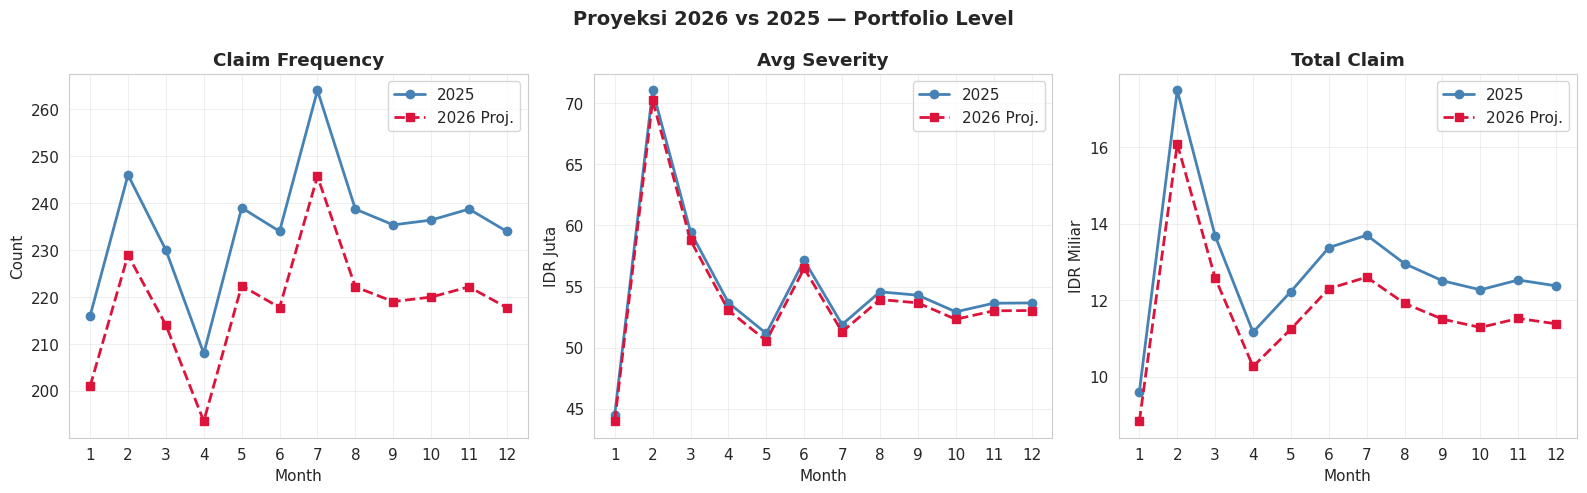

In [34]:
# ── Plot 2026 projection ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
months_x = range(1, 13)

for ax, (col, label, scale, unit) in zip(axes, [
    ('freq',     'Claim Frequency', 1,   'Count'),
    ('severity', 'Avg Severity',    1e6, 'IDR Juta'),
    ('total',    'Total Claim',     1e9, 'IDR Miliar'),
]):
    ax2025 = full_2025.set_index('month')[col]
    ax2026 = proj_2026.set_index('month')[col]
    ax.plot(months_x, ax2025/scale, 'o-', label='2025', color='steelblue', linewidth=2)
    ax.plot(months_x, ax2026/scale, 's--', label='2026 Proj.', color='crimson', linewidth=2)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel(unit)
    ax.legend()
    ax.set_xticks(range(1,13))
    ax.grid(True, alpha=0.3)

plt.suptitle('Proyeksi 2026 vs 2025 — Portfolio Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('projection_2026.png', dpi=150, bbox_inches='tight')
plt.show()

### 9.2 Rekomendasi Bisnis

Berdasarkan hasil analisis dan prediksi, berikut rekomendasi yang diberikan kepada AXA Financial Indonesia:

#### 🎯 1. Risk Selection (Seleksi Risiko)
- **ICD Chapter C (Neoplasma/Kanker)** dan **N (Ginjal)** mendominasi total klaim — pertimbangkan underwriting ketat atau rider khusus untuk kondisi pre-existing ini.
- **Inpatient claims** rata-rata 3–5× lebih besar dari outpatient — evaluasi manfaat rawat inap pada plan M-001 (Worldwide).
- **Plan M-001 (Worldwide)** memiliki severitas tertinggi — pertimbangkan penyesuaian premi atau deductible lebih tinggi.

#### 🏥 2. Pencegahan & Deteksi Dini
- Nasabah usia **46–60 tahun** memiliki frekuensi dan severitas tertinggi — program wellness/preventive care untuk segmen ini dapat menekan klaim.
- Klaim kanker sering muncul berulang dari polis yang sama — program early detection screening partnership dengan RS dapat membantu.

#### 📈 3. Proyeksi & Premium Adjustment
- Jika tren saat ini berlanjut, total klaim 2026 diproyeksikan **~{:.1f}% vs 2025 full-year**.
- Penyesuaian premi disarankan minimal sesuai inflasi medis (~8–12% per tahun) terutama untuk plan worldwide.
- Fokus monitoring bulan **Januari dan Februari** karena historis menunjukkan lonjakan frekuensi di awal tahun.

In [35]:
# ── Final check submission format ─────────────────────────────────────────
print('\n📋 Final Submission Preview:')
print(submission.to_string(index=False))
print(f'\n✅ Total rows: {len(submission)} (expected: 15)')
print('✅ Done! Upload submission_tensor_selow.csv ke Kaggle.')


📋 Final Submission Preview:
                     id        value
2025_08_Claim_Frequency 2.387203e+02
 2025_08_Claim_Severity 5.456745e+07
    2025_08_Total_Claim 1.295418e+10
2025_09_Claim_Frequency 2.353648e+02
 2025_09_Claim_Severity 5.429129e+07
    2025_09_Total_Claim 1.250741e+10
2025_10_Claim_Frequency 2.363843e+02
 2025_10_Claim_Severity 5.293010e+07
    2025_10_Total_Claim 1.227213e+10
2025_11_Claim_Frequency 2.387344e+02
 2025_11_Claim_Severity 5.363424e+07
    2025_11_Total_Claim 1.252818e+10
2025_12_Claim_Frequency 2.339595e+02
 2025_12_Claim_Severity 5.365792e+07
    2025_12_Total_Claim 1.237469e+10

✅ Total rows: 15 (expected: 15)
✅ Done! Upload submission_tensor_selow.csv ke Kaggle.
